# Julia is Fast
### Looking At Speed of Julia

original source: https://www.youtube.com/watch?v=4igzy3bGVkQ 

Modified to show 

Comparison of R, python, Julia, and C




### Simple example to show Julia's speed

## `sum` : An easy enough function to understand

Consider the **sum** function sum(a), which computes $$\mathrm{sum}({a}) = \sum_{i=1}^n a_i, $$ where $n$ is the length of `a`.

In [1]:
a = rand(10^7); # 1 D vector of random numbers, uniform on [0,1)

In [2]:
sum(a)

4.999778260403143e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

## Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking

Executes the same code numerous time and takes average to show better estimates. 

`@time` **macro** works but may not give adequate stats like to combat what you might have going on, on your laptop in the background for instance. Plus, we may only run that once


In [3]:
#Pkg.add("BenchmarkTools")

In [3]:
using BenchmarkTools

## The C Language

C is considered the gold standard: difficult on the human, nice on the machined. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, ther are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

You can put C code in a Julia Session, compile it and run it. Note that ` """` wrap a multi-line string

In [4]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()  #make a temporary file

#Compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * 
Libdl.dlext) - `, "w") do f
    print(f, C_code)
end

#define a Julia Function that calls the C function:
c_sum(X::Array{Float64}) = ccall( ("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X),X)

c_sum (generic function with 1 method)

In [5]:
c_sum(a) #Running the C function

4.9997782604030175e6

Comparing the output our `C` function `c_sum(a)` to our Julia function 
`sum(a)` using the $\approx$ alias for `isapprox` function

In [6]:
c_sum(a) ≈ sum(a) #type \approx and then <TAB> to get the ≈ symbol

true

In [7]:
≈ # alias for the `isapprox` function

isapprox (generic function with 3 methods)

In [9]:
#?isapprox # -- show isapprox function information

In [7]:
1 ≈ 1.00000001

true

### 1. Benchmarking the C code directly from Julia

In [8]:
c_bench = @benchmark c_sum($a) #output of the benchmark tools

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.863 ms (0.00% GC)
  median time:      9.043 ms (0.00% GC)
  mean time:        9.495 ms (0.00% GC)
  maximum time:     13.623 ms (0.00% GC)
  --------------
  samples:          527
  evals/sample:     1

In [9]:
c_bench.times;

In [10]:
println("C: Fastest time was $(minimum(c_bench.times)/1e6) ms")

C: Fastest time was 8.863466 ms


In [11]:
# Start saving our results in dictionary for later comparison
d = Dict() # A "dictionary, i.e. an associative array
d["C"] = minimum(c_bench.times)/1e6 # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 8.86347

In [12]:
using Plots
gr()

Plots.GRBackend()

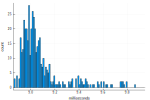

In [13]:
t = c_bench.times/1e6
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

### 2. Benchmarking Python's Built in `sum` function

In [45]:
using PyCall

In [46]:
#Call a low-level Pycall Function to get a Python list, beacuse
#by Default Pycall will convert to a NumPy array instead 
# (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

#get the Python built-in "sum" function 
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [47]:
pysum(a)

4.9997782604030175e6

In [48]:
pysum(a) ≈ sum(a)

true

In [49]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  4
  --------------
  minimum time:     97.666 ms (0.00% GC)
  median time:      103.464 ms (0.00% GC)
  mean time:        105.555 ms (0.00% GC)
  maximum time:     155.440 ms (0.00% GC)
  --------------
  samples:          48
  evals/sample:     1

In [50]:
d["Python bulit-in"] = minimum(py_list_bench.times) /1e6
d

Dict{Any,Any} with 6 entries:
  "Python bulit-in"    => 97.6658
  "C"                  => 8.86347
  "Julia hand-written" => 8.89364
  "R Built-in"         => 44.972
  "R handwritten"      => 322.729
  "Julia Built-in"     => 3.93885

### 3. Benchmarking Python: `numpy`
Takes advantage of Hardware "SIMD", but only works when it works.

SIMD = Single Instruction, Multple Data 
https://en.wikipedia.org/wiki/SIMD

A class of parallel computers. It describes computers with multiple processing elements that perform the same operation on multiple data points simultaneously. Exploit data level parallelism, but not concurrency: simultaneous (parallel) computations, but only a single process (instruction) at a given moment. 

concurrency is a form of computing in which several computations are executed during overlapping time periods *-concurrently-* instead of sequentially (one completing before the next starts)

`numpy` is an **optimized C library**, callable from Python. It may be installed within Julia as follows:

In [56]:
using Conda
Conda.add("numpy")

Info: Running `conda install -y numpy` in root environment
/Users/lhester/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


Solving environment: ...working... done

# All requested packages already installed.



In [57]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) #Converts to a numpy array by default

py_numpy_bench = @benchmark $ numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  4
  --------------
  minimum time:     4.188 ms (0.00% GC)
  median time:      4.785 ms (0.00% GC)
  mean time:        4.948 ms (0.00% GC)
  maximum time:     17.316 ms (0.00% GC)
  --------------
  samples:          1008
  evals/sample:     1

In [53]:
numpy_sum(apy_list) # python thing

4.999778260403144e6

In [54]:
numpy_sum(apy_list) ≈ sum(a)

true

In [58]:
d["Python numpy"] = minimum(py_numpy_bench.times)/1e6
d

Dict{Any,Any} with 7 entries:
  "Python bulit-in"    => 97.6658
  "C"                  => 8.86347
  "Julia hand-written" => 8.89364
  "Python numpy"       => 4.18784
  "R Built-in"         => 44.972
  "R handwritten"      => 322.729
  "Julia Built-in"     => 3.93885

### 4. Benchmarking Python Hand-written function

In [59]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x14745d578>

In [60]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  4
  --------------
  minimum time:     488.315 ms (0.00% GC)
  median time:      534.843 ms (0.00% GC)
  mean time:        529.734 ms (0.00% GC)
  maximum time:     558.677 ms (0.00% GC)
  --------------
  samples:          10
  evals/sample:     1

In [61]:
sum_py(apy_list)

4.9997782604030175e6

In [62]:
sum_py(apy_list) ≈ sum(a)

true

In [63]:
d["Python hand-written"] = minimum(py_hand.times)/1e6
d

Dict{Any,Any} with 8 entries:
  "Python bulit-in"     => 97.6658
  "C"                   => 8.86347
  "Julia hand-written"  => 8.89364
  "Python numpy"        => 4.18784
  "Python hand-written" => 488.315
  "R Built-in"          => 44.972
  "R handwritten"       => 322.729
  "Julia Built-in"      => 3.93885

### 5. Benchmarking Julia 
Written directly in Julia, not in C!

In [64]:
@which sum(a)

sum(a) in Base at reduce.jl:359

In [65]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.915 ms (0.00% GC)
  median time:      4.302 ms (0.00% GC)
  mean time:        4.447 ms (0.00% GC)
  maximum time:     7.753 ms (0.00% GC)
  --------------
  samples:          1123
  evals/sample:     1

In [66]:
d["Julia Built-in"] = minimum(j_bench.times)/1e6
d

Dict{Any,Any} with 8 entries:
  "Python bulit-in"     => 97.6658
  "C"                   => 8.86347
  "Julia hand-written"  => 8.89364
  "Python numpy"        => 4.18784
  "Python hand-written" => 488.315
  "R Built-in"          => 44.972
  "R handwritten"       => 322.729
  "Julia Built-in"      => 3.91479

### 6. Benchmarking Julia (hand-written)

In [67]:
function mysum(A)
    s = 0.0 #s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [68]:
j_bench_hand = @benchmark mysum($a)
d["Julia hand-written"] = minimum(j_bench_hand.times)/1e6
d

Dict{Any,Any} with 8 entries:
  "Python bulit-in"     => 97.6658
  "C"                   => 8.86347
  "Julia hand-written"  => 8.88477
  "Python numpy"        => 4.18784
  "Python hand-written" => 488.315
  "R Built-in"          => 44.972
  "R handwritten"       => 322.729
  "Julia Built-in"      => 3.91479

### 7. Benchmarking R's Built in `sum` function

ref:http://luiarthur.github.io/usingrcall

In [69]:
using RCall
#get the R built-in "sum" function 
rsum = R"sum"

RCall.RObject{RCall.BuiltinSxp}
function (..., na.rm = FALSE)  .Primitive("sum")


In [70]:
Float64(rsum(a)) #output of R is an R object type

4.999778260403143e6

In [71]:
Float64(rsum(a)) ≈ sum(a)

true

In [72]:
#py_list_bench = @benchmark $pysum($apy_list)
r_bench = @benchmark $rsum($a)

BenchmarkTools.Trial: 
  memory estimate:  912 bytes
  allocs estimate:  28
  --------------
  minimum time:     60.152 ms (0.00% GC)
  median time:      68.088 ms (0.00% GC)
  mean time:        67.864 ms (0.00% GC)
  maximum time:     78.304 ms (0.00% GC)
  --------------
  samples:          74
  evals/sample:     1

In [73]:
d["R Built-in"] = minimum(r_bench.times)/1e6
d

Dict{Any,Any} with 8 entries:
  "Python bulit-in"     => 97.6658
  "C"                   => 8.86347
  "Julia hand-written"  => 8.88477
  "Python numpy"        => 4.18784
  "Python hand-written" => 488.315
  "R Built-in"          => 60.1519
  "R handwritten"       => 322.729
  "Julia Built-in"      => 3.91479

### 8. Benchmarking R Hand-written function

In [74]:
sum_r = R"
r_sum <- function(a){

    s = 0.0
    for (x in a){
        s = s + x
    }
    return (s)
}
"

RCall.RObject{RCall.ClosSxp}
function (a) 
{
    s = 0
    for (x in a) {
        s = s + x
    }
    return(s)
}


In [75]:
Float64(sum_r(a))

4.9997782604030175e6

In [76]:
Float64(sum_r(a)) ≈ sum(a)

true

In [77]:
R_bench_hand = @benchmark sum_r($a)

BenchmarkTools.Trial: 
  memory estimate:  960 bytes
  allocs estimate:  30
  --------------
  minimum time:     312.749 ms (0.00% GC)
  median time:      344.696 ms (0.00% GC)
  mean time:        343.135 ms (0.00% GC)
  maximum time:     369.294 ms (0.00% GC)
  --------------
  samples:          15
  evals/sample:     1

In [78]:
d["R handwritten"] = minimum(R_bench_hand.times)/1e6
d

Dict{Any,Any} with 8 entries:
  "Python bulit-in"     => 97.6658
  "C"                   => 8.86347
  "Julia hand-written"  => 8.88477
  "Python numpy"        => 4.18784
  "Python hand-written" => 488.315
  "R Built-in"          => 60.1519
  "R handwritten"       => 312.749
  "Julia Built-in"      => 3.91479

# Summary 

In [79]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, 1), 8, "."))
end

C........................8.9
Julia Built-in...........3.9
Julia hand-written.......8.9
Python bulit-in.........97.7
Python hand-written....488.3
Python numpy.............4.2
R Built-in..............60.2
R handwritten..........312.7


In [80]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, 2), 10, "."))
end



# Results in milliseconds (ms)

Julia Built-in............3.91
Python numpy..............4.19
C.........................8.86
Julia hand-written........8.88
R Built-in...............60.15
Python bulit-in..........97.67
R handwritten...........312.75
Python hand-written.....488.32


Built-in Julia is the best and then handwritten Julia is still in the Top 4